Создать программу для решения простых дифференциальных уравнений с помощью функции ядра, используйте метод Эйлера или метод Рунге-Кутты .

In [2]:
pip install pyopencl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.2/715.2 kB 1.3 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 598.5 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pyopencl as cl

# Уравнение: dy/dx = -y, y(0) = 1

# Константы
num_steps = 1000
delta_x = 0.1
initial_y = 1.0

# Создаем контекст для выполнения кода на устройстве (GPU или CPU)
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

# Создаем ядро OpenCL
kernel_code = """
__kernel void euler(__global float* y, const float delta_x, const int num_steps) {
    int gid = get_global_id(0);
    float dydx;
    for (int i = 0; i < num_steps; ++i) {
        dydx = -y[0];
        y[0] += dydx * delta_x;
    }
}
"""

program = cl.Program(ctx, kernel_code).build()

# Создаем буферы данных
y_buffer = cl.Buffer(ctx, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.array([initial_y], dtype=np.float32))

# Выполняем вычисления
program.euler(queue, (1,), None, y_buffer, np.float32(delta_x), np.int32(num_steps))

# Читаем результаты
result = np.empty_like([initial_y], dtype=np.float32)
cl.enqueue_copy(queue, result, y_buffer).wait()

print("Результат методом Эйлера:", result[0])


Результат методом Эйлера: 6e-45


Создать программу для приближенного вычисления числа Пи с помощью функции ядра, используйте метод Монте-Карло.

In [2]:
import pyopencl as cl
import numpy as np
import random

# Создание контекста и очереди команд
platform = cl.get_platforms()[0]
device = platform.get_devices()[0]
context = cl.Context([device])
queue = cl.CommandQueue(context)

# Количество случайных точек, которые мы будем использовать для оценки
num_points = 1000000

# Генерация случайных чисел на хосте
random_numbers = np.random.rand(num_points).astype(np.float32)

# Задаем программу OpenCL
program_src = """
__kernel void estimate_pi(__global float* result, __global float* random_numbers) {
    unsigned int idx = get_global_id(0);
    unsigned int count = 0;
    float x, y;

    // Используем предварительно сгенерированные случайные числа
    unsigned int offset = idx * %d;

    // Генерируем случайные точки и проверяем, попадают ли они в круг
    for(unsigned int i = 0; i < %d; ++i) {
        x = random_numbers[offset + i];
        y = random_numbers[offset + i + 1];

        if (x*x + y*y <= 1.0f)
            count++;
    }

    // Вычисляем приближенное значение числа Пи
    result[idx] = 4.0f * (float)count / %d;
}
""" % (num_points, num_points, num_points)

# Компилируем программу
program = cl.Program(context, program_src).build()

# Создаем буферы для хранения результатов и случайных чисел
result = np.zeros(1, dtype=np.float32)
result_buffer = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, result.nbytes)
random_numbers_buffer = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=random_numbers)

# Запускаем ядро OpenCL для оценки числа Пи
program.estimate_pi(queue, (1,), None, result_buffer, random_numbers_buffer)
cl.enqueue_copy(queue, result, result_buffer).wait()

print("Приближенное значение числа Пи:", result[0])


Приближенное значение числа Пи: 3.14182


Реализовать с использованием функций ядра в PyOpenCL фракталы:

множество Бернса-Шиппена

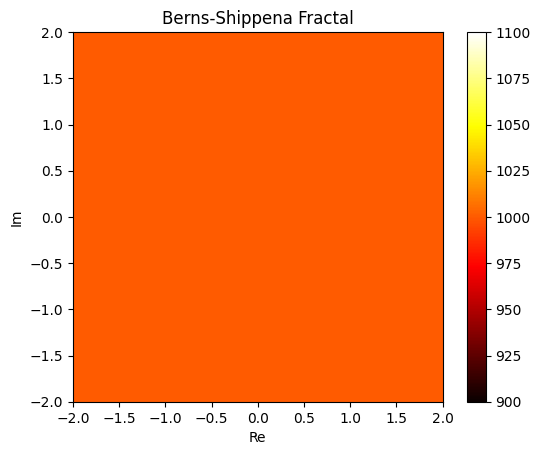

In [3]:
import numpy as np
import pyopencl as cl
from pyopencl import array
import matplotlib.pyplot as plt

def berns_shippena_fractal(width, height, max_iterations=1000, threshold=100):
    # Создаем OpenCL контекст и очередь команд
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)

    # Загружаем ядро OpenCL
    kernel_code = """
    __kernel void berns_shippena(__global float2 *output, int max_iterations, float threshold) {
        int gid = get_global_id(0);
        float2 c = output[gid];
        float2 z = (float2)(0.0f, 0.0f);
        int i = 0;
        for (i = 0; i < max_iterations; i++) {
            float2 temp = (float2)(z.x * z.x - z.y * z.y + c.x, 2.0f * fabs(z.x * z.y) + c.y);
            if (temp.x * temp.x + temp.y * temp.y > threshold) {
                break;
            }
            z = temp;
        }
        output[gid] = (float2)((float)i, 0.0f);
    }
    """

    # Компилируем ядро OpenCL
    prg = cl.Program(ctx, kernel_code).build()

    # Создаем буфер для хранения результатов
    output = np.zeros((width * height, 2), dtype=np.float32)
    output_buf = cl.Buffer(ctx, cl.mem_flags.WRITE_ONLY, output.nbytes)

    # Вычисляем множество Бернса-Шиппена на GPU
    prg.berns_shippena(queue, (width * height,), None, output_buf, np.int32(max_iterations), np.float32(threshold))
    cl.enqueue_copy(queue, output, output_buf).wait()

    # Преобразуем результаты в изображение
    image = np.zeros((height, width), dtype=np.float32)
    for i in range(height):
        for j in range(width):
            image[i, j] = output[i * width + j][0]

    return image

# Параметры для генерации фрактала
width = 1000
height = 1000
max_iterations = 1000
threshold = 100

# Генерируем фрактал
fractal = berns_shippena_fractal(width, height, max_iterations, threshold)

# Отображаем результат
plt.imshow(fractal, cmap='hot', extent=(-2, 2, -2, 2))
plt.colorbar()
plt.title('Berns-Shippena Fractal')
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()


множество Ньютона

In [4]:
import numpy as np
import pyopencl as cl
from pyopencl import array
import matplotlib.pyplot as plt

def newton_fractal(width, height, max_iterations=100, threshold=1e-6):
    # Создаем OpenCL контекст и очередь команд
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)

    # Загружаем ядро OpenCL
    kernel_code = """
    __kernel void newton(__global float2 *output, int max_iterations, float threshold) {
        int gid = get_global_id(0);
        float2 z0 = output[gid];
        float2 z = z0;
        int i = 0;
        for (i = 0; i < max_iterations; i++) {
            float2 dz = (float2)(
                3.0f * z.x * z.x - 3.0f * z.y * z.y + 1.0f,
                6.0f * z.x * z.y
            );
            z -= (z * z * z - 1.0f) / dz;
            if (abs(z.x * z.x + z.y * z.y - 1.0f) < threshold) {
                break;
            }
        }
        output[gid] = (float2)((float)i, 0.0f);
    }
    """

    # Компилируем ядро OpenCL
    prg = cl.Program(ctx, kernel_code).build()

    # Создаем буфер для хранения результатов
    output = np.zeros((width * height, 2), dtype=np.float32)
    output_buf = cl.Buffer(ctx, cl.mem_flags.WRITE_ONLY, output.nbytes)

    # Вычисляем множество Ньютона на GPU
    prg.newton(queue, (width * height,), None, output_buf, np.int32(max_iterations), np.float32(threshold))
    cl.enqueue_copy(queue, output, output_buf).wait()

    # Преобразуем результаты в изображение
    image = np.zeros((height, width), dtype=np.float32)
    for i in range(height):
        for j in range(width):
            image[i, j] = output[i * width + j][0]

    return image

# Параметры для генерации фрактала
width = 1000
height = 1000
max_iterations = 100
threshold = 1e-6

# Генерируем фрактал
fractal = newton_fractal(width, height, max_iterations, threshold)

# Отображаем результат
plt.imshow(fractal, cmap='hot', extent=(-2, 2, -2, 2))
plt.colorbar()
plt.title('Newton Fractal')
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()


RuntimeError: clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE

Build on <pyopencl.Device 'Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz' on 'Apple' at 0xffffffff>:

<program source>:13:17: error: call to '__cl_abs' is ambiguous
            if (abs(z.x * z.x + z.y * z.y - 1.0f) < threshold) {
                ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4770:22: note: expanded from macro 'abs'
    #define abs(__x) __cl_abs(__x)
                     ^~~~~~~~
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:659:53: note: expanded from macro '__CLFN_UCSIL_1CSIL'
#define __CLFN_UCSIL_1CSIL(name) uchar __OVERLOAD__ name(char x); \
                                                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:660:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar2 __OVERLOAD__ name(char2 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:661:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar3 __OVERLOAD__ name(char3 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:662:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar4 __OVERLOAD__ name(char4 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:663:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar8 __OVERLOAD__ name(char8 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:664:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar16 __OVERLOAD__ name(char16 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:665:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar __OVERLOAD__ name(uchar x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:666:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar2 __OVERLOAD__ name(uchar2 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:667:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar3 __OVERLOAD__ name(uchar3 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:668:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar4 __OVERLOAD__ name(uchar4 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:669:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar8 __OVERLOAD__ name(uchar8 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:670:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uchar16 __OVERLOAD__ name(uchar16 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:671:19: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint __OVERLOAD__ name(int x); \
                  ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:672:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint2 __OVERLOAD__ name(int2 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:673:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint3 __OVERLOAD__ name(int3 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:674:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint4 __OVERLOAD__ name(int4 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:675:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint8 __OVERLOAD__ name(int8 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:676:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint16 __OVERLOAD__ name(int16 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:677:19: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint __OVERLOAD__ name(uint x); \
                  ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:678:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint2 __OVERLOAD__ name(uint2 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:679:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint3 __OVERLOAD__ name(uint3 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:680:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint4 __OVERLOAD__ name(uint4 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:681:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint8 __OVERLOAD__ name(uint8 x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:682:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
uint16 __OVERLOAD__ name(uint16 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:683:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort __OVERLOAD__ name(short x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:684:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort2 __OVERLOAD__ name(short2 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:685:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort3 __OVERLOAD__ name(short3 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:686:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort4 __OVERLOAD__ name(short4 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:687:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort8 __OVERLOAD__ name(short8 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:688:23: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort16 __OVERLOAD__ name(short16 x); \
                      ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:689:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort __OVERLOAD__ name(ushort x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:690:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort2 __OVERLOAD__ name(ushort2 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:691:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort3 __OVERLOAD__ name(ushort3 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:692:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort4 __OVERLOAD__ name(ushort4 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:693:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort8 __OVERLOAD__ name(ushort8 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:694:23: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ushort16 __OVERLOAD__ name(ushort16 x); \
                      ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:695:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong __OVERLOAD__ name(long x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:696:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong2 __OVERLOAD__ name(long2 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:697:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong3 __OVERLOAD__ name(long3 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:698:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong4 __OVERLOAD__ name(long4 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:699:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong8 __OVERLOAD__ name(long8 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:700:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong16 __OVERLOAD__ name(long16 x); \
                     ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:701:20: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong __OVERLOAD__ name(ulong x); \
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:702:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong2 __OVERLOAD__ name(ulong2 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:703:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong3 __OVERLOAD__ name(ulong3 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:704:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong4 __OVERLOAD__ name(ulong4 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:705:21: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong8 __OVERLOAD__ name(ulong8 x); \
                    ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:4767:20: note: candidate function
__CLFN_UCSIL_1CSIL(__cl_abs);
                   ^
/System/Library/Frameworks/OpenCL.framework/Versions/A/lib/clang/3.2/include/cl_kernel.h:706:22: note: expanded from macro '__CLFN_UCSIL_1CSIL'
ulong16 __OVERLOAD__ name(ulong16 x); 
                     ^

(options: -I /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyopencl/cl)
(source saved as /var/folders/dj/_5hxpqs5515ff9d6vcqd7tq40000gn/T/tmpl62td21o.cl)